In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import pyplot

# Arima model
source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [2]:
path = open('document.txt', 'r').read().strip()
os.listdir(f'{path}')

df_arima = pd.DataFrame([])
for year in range(2015,2019):
    df_data = pd.read_feather(f"{path}/{year}_street.feather")
    filter = df_data['Falls within'].str.contains('South Wales')
    df_data = df_data[filter]
    df_data = df_data[df_data['Crime type']=='Violence and sexual offences']
    df_data = df_data['Month'].value_counts().sort_index()
    df_arima = pd.concat([df_arima, df_data])
    del df_data

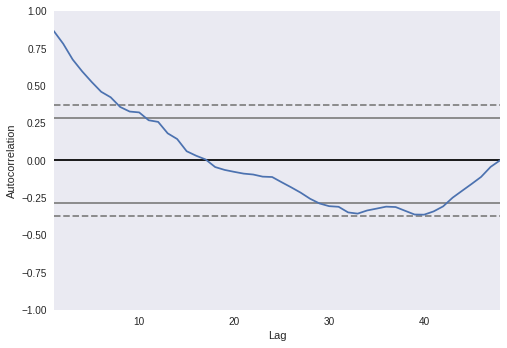

In [3]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_arima);

In [4]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_arima, order=(8,1,0));
model_fit = model.fit();
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                   48
Model:                 ARIMA(8, 1, 0)   Log Likelihood                -308.726
Date:                Thu, 17 Mar 2022   AIC                            635.453
Time:                        11:56:51   BIC                            652.104
Sample:                    01-01-2015   HQIC                           641.719
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3727      0.181     -2.055      0.040      -0.728      -0.017
ar.L2          0.1097      0.171      0.643      0.521      -0.225       0.444
ar.L3         -0.0923      0.253     -0.364      0.7

/home/dazai/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/dazai/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/dazai/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


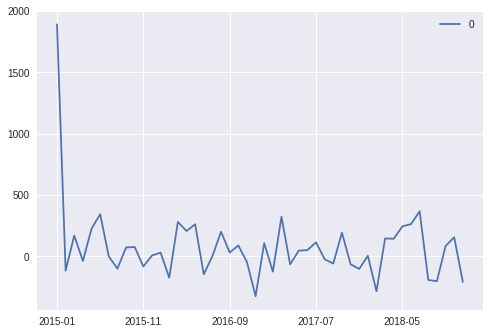

In [5]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot();

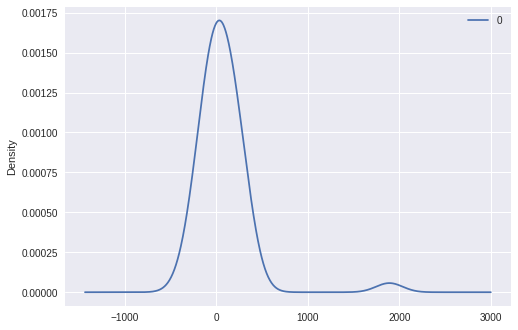

In [6]:
residuals.plot(kind='kde');

In [7]:
print(residuals.describe())

                 0
count    48.000000
mean     79.798806
std     315.108859
min    -323.798111
25%     -68.665743
50%      39.840439
75%     176.807750
max    1892.000000


predicted=2896.252494, expected=2969.000000
predicted=2769.821470, expected=2960.000000
predicted=3020.594956, expected=3322.000000
predicted=3150.095033, expected=3450.000000
predicted=3398.354757, expected=3801.000000
predicted=3763.098305, expected=3464.000000
predicted=3554.509101, expected=3321.000000
predicted=3210.923574, expected=3359.000000
predicted=3300.879064, expected=3484.000000
predicted=3595.202817, expected=3292.000000
Test RMSE: 259.952


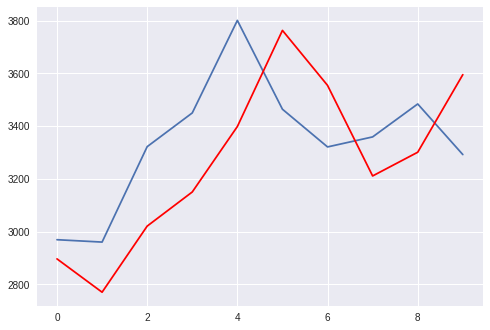

In [8]:
from sklearn.metrics import mean_squared_error
# df_arima.index = df_arima.index.to_period('M')

# split into train and test sets
X = df_arima.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(8,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
 
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()